# Capstone Project: Multi-Asset ML Trading System

## 🎯 Project Overview

Build a complete end-to-end ML trading system that:
1. Downloads and processes multi-asset data
2. Engineers features using techniques from Weeks 1-24
3. Trains ensemble ML models with proper validation
4. Generates next-day trading signals with confidence scores
5. Implements portfolio optimization and risk management

## ⏱️ Time Allocation
| Phase | Duration |
|-------|----------|
| Data Pipeline | 1 hour |
| Feature Engineering | 2 hours |
| Model Training | 2 hours |
| Signal Generation | 1 hour |
| Backtesting | 2 hours |

In [1]:
# Complete Multi-Asset ML Trading System
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

print("="*70)
print("CAPSTONE: MULTI-ASSET ML TRADING SYSTEM")
print("="*70)
print(f"\nDate: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

CAPSTONE: MULTI-ASSET ML TRADING SYSTEM

Date: 2026-01-24 11:22


## Phase 1: Data Pipeline

Download multi-asset data including:
- Individual stocks (AAPL, GOOGL, MSFT, GS, JPM)
- Market indices (SPY)
- Sector ETFs for context

In [2]:
# Phase 1: Data Download
print("\n" + "="*60)
print("PHASE 1: DATA PIPELINE")
print("="*60)

# Target stocks for trading
STOCKS = ['AAPL', 'GOOGL', 'MSFT', 'GS', 'JPM']

# Market context
MARKET = ['SPY', 'QQQ', 'XLF']  # S&P 500, Tech, Financials

ALL_TICKERS = STOCKS + MARKET

# Download data
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print(f"📥 Downloading data for {len(ALL_TICKERS)} tickers...")
data = yf.download(ALL_TICKERS, start=start_date, end=end_date, progress=False, auto_adjust=True)

prices = data['Close'].dropna()
volumes = data['Volume'].dropna()
high = data['High'].dropna()
low = data['Low'].dropna()

print(f"✅ Downloaded {len(prices)} days of data")
print(f"   Date range: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"   Stocks: {STOCKS}")
print(f"   Market indices: {MARKET}")


PHASE 1: DATA PIPELINE
📥 Downloading data for 8 tickers...
✅ Downloaded 1256 days of data
   Date range: 2021-01-25 to 2026-01-23
   Stocks: ['AAPL', 'GOOGL', 'MSFT', 'GS', 'JPM']
   Market indices: ['SPY', 'QQQ', 'XLF']


## Phase 2: Feature Engineering

Create comprehensive features:
1. **Price-based**: Returns, momentum, mean reversion
2. **Technical indicators**: RSI, MACD, Bollinger Bands
3. **Volatility**: Rolling std, ATR, GARCH-like
4. **Cross-asset**: Beta, correlations, relative strength

In [3]:
# Phase 2: Feature Engineering
print("\n" + "="*60)
print("PHASE 2: FEATURE ENGINEERING")
print("="*60)

def create_features(prices, volumes, high, low, stock, market='SPY'):
    """Create comprehensive feature set for a single stock."""
    df = pd.DataFrame(index=prices.index)
    
    # Basic returns
    returns = prices[stock].pct_change()
    df['returns'] = returns
    
    # Lagged returns (momentum features)
    for lag in [1, 2, 3, 5, 10, 21]:
        df[f'ret_lag_{lag}'] = returns.shift(lag)
    
    # Momentum indicators
    df['momentum_5'] = prices[stock].pct_change(5).shift(1)
    df['momentum_21'] = prices[stock].pct_change(21).shift(1)
    
    # Mean reversion
    df['mean_rev_20'] = (prices[stock] / prices[stock].rolling(20).mean() - 1).shift(1)
    df['mean_rev_50'] = (prices[stock] / prices[stock].rolling(50).mean() - 1).shift(1)
    
    # Volatility features
    df['volatility_10'] = returns.rolling(10).std().shift(1)
    df['volatility_21'] = returns.rolling(21).std().shift(1)
    df['volatility_ratio'] = (df['volatility_10'] / df['volatility_21']).shift(1)
    
    # RSI
    delta = prices[stock].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['rsi_14'] = (100 - (100 / (1 + rs))).shift(1)
    
    # Bollinger Band position
    bb_middle = prices[stock].rolling(20).mean()
    bb_std = prices[stock].rolling(20).std()
    df['bb_position'] = ((prices[stock] - bb_middle) / (2 * bb_std)).shift(1)
    
    # Volume features
    df['volume_ratio'] = (volumes[stock] / volumes[stock].rolling(20).mean()).shift(1)
    
    # Cross-asset features (market context)
    market_returns = prices[market].pct_change()
    df['market_ret'] = market_returns.shift(1)
    
    # Rolling beta
    cov = returns.rolling(60).cov(market_returns)
    var = market_returns.rolling(60).var()
    df['beta_60'] = (cov / var).shift(1)
    
    # Relative strength vs market
    df['rel_strength'] = (returns.rolling(21).mean() - market_returns.rolling(21).mean()).shift(1)
    
    # Target: Next day direction (1 = up, 0 = down)
    df['target'] = (returns.shift(-1) > 0).astype(int)
    
    return df.dropna()

# Create features for all stocks
all_features = {}
for stock in STOCKS:
    all_features[stock] = create_features(prices, volumes, high, low, stock)
    print(f"  {stock}: {len(all_features[stock])} samples, {len(all_features[stock].columns)-1} features")

print(f"\n✅ Feature engineering complete")


PHASE 2: FEATURE ENGINEERING
  AAPL: 1195 samples, 20 features
  GOOGL: 1195 samples, 20 features
  MSFT: 1195 samples, 20 features
  GS: 1195 samples, 20 features
  JPM: 1195 samples, 20 features

✅ Feature engineering complete


## Phase 3: Model Training

Train an ensemble of models:
1. Logistic Regression (baseline)
2. Random Forest (non-linear patterns)
3. Gradient Boosting (sequential learning)

Use proper time series cross-validation.

In [4]:
# Phase 3: Model Training
print("\n" + "="*60)
print("PHASE 3: MODEL TRAINING")
print("="*60)

def train_ensemble(df, stock):
    """Train ensemble of models with time series CV."""
    feature_cols = [c for c in df.columns if c not in ['returns', 'target']]
    X = df[feature_cols]
    y = df['target']
    
    # Time series split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train models
    models = {
        'Logistic': LogisticRegression(max_iter=1000, random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
    }
    
    results = {}
    predictions = {}
    probabilities = {}
    
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }
        predictions[name] = y_pred
        probabilities[name] = y_prob
    
    # Ensemble prediction (average probabilities)
    ensemble_prob = np.mean([probabilities[m] for m in models.keys()], axis=0)
    ensemble_pred = (ensemble_prob > 0.5).astype(int)
    
    results['Ensemble'] = {
        'accuracy': accuracy_score(y_test, ensemble_pred),
        'precision': precision_score(y_test, ensemble_pred),
        'recall': recall_score(y_test, ensemble_pred),
        'f1': f1_score(y_test, ensemble_pred)
    }
    
    return models, scaler, results, X_test.index, ensemble_prob

# Train models for all stocks
trained_models = {}
scalers = {}
all_results = {}

for stock in STOCKS:
    print(f"\nTraining models for {stock}...")
    models, scaler, results, test_idx, probs = train_ensemble(all_features[stock], stock)
    trained_models[stock] = models
    scalers[stock] = scaler
    all_results[stock] = results
    
    print(f"  Ensemble Accuracy: {results['Ensemble']['accuracy']:.2%}")

print(f"\n✅ All models trained")


PHASE 3: MODEL TRAINING

Training models for AAPL...
  Ensemble Accuracy: 52.30%

Training models for GOOGL...
  Ensemble Accuracy: 54.81%

Training models for MSFT...
  Ensemble Accuracy: 53.97%

Training models for GS...
  Ensemble Accuracy: 54.81%

Training models for JPM...
  Ensemble Accuracy: 53.56%

✅ All models trained


## Phase 4: Generate Trading Signals

Generate next-day predictions for all stocks with confidence scores.

In [5]:
# Phase 4: Generate Trading Signals
print("\n" + "="*60)
print("PHASE 4: TRADING SIGNAL GENERATION")
print("="*60)

def generate_signals(stock, features_df, models, scaler):
    """Generate trading signal for next day."""
    feature_cols = [c for c in features_df.columns if c not in ['returns', 'target']]
    
    # Get latest features
    latest = features_df[feature_cols].iloc[-1:]
    latest_scaled = scaler.transform(latest)
    
    # Get predictions from all models
    probabilities = []
    for name, model in models.items():
        prob = model.predict_proba(latest_scaled)[0, 1]
        probabilities.append(prob)
    
    # Ensemble probability
    ensemble_prob = np.mean(probabilities)
    
    # Generate signal
    if ensemble_prob > 0.55:
        signal = 'BUY'
    elif ensemble_prob < 0.45:
        signal = 'SELL'
    else:
        signal = 'HOLD'
    
    # Confidence (distance from 0.5)
    confidence = abs(ensemble_prob - 0.5) * 2 * 100  # 0-100%
    
    return {
        'signal': signal,
        'probability': ensemble_prob,
        'confidence': confidence,
        'model_probs': dict(zip(models.keys(), probabilities))
    }

# Generate signals for all stocks
print(f"\n{'='*70}")
print(f"NEXT-DAY TRADING SIGNALS - {datetime.now().strftime('%Y-%m-%d')}")
print(f"{'='*70}")

signals_summary = []

for stock in STOCKS:
    signal_info = generate_signals(
        stock, 
        all_features[stock], 
        trained_models[stock], 
        scalers[stock]
    )
    
    latest_price = prices[stock].iloc[-1]
    
    print(f"\n📊 {stock}")
    print(f"   Current Price: ${latest_price:.2f}")
    print(f"   Signal: {signal_info['signal']}")
    print(f"   Probability (up): {signal_info['probability']:.1%}")
    print(f"   Confidence: {signal_info['confidence']:.1f}%")
    
    signals_summary.append({
        'Stock': stock,
        'Price': latest_price,
        'Signal': signal_info['signal'],
        'Prob_Up': signal_info['probability'],
        'Confidence': signal_info['confidence']
    })

# Summary table
signals_df = pd.DataFrame(signals_summary)
print(f"\n{'='*70}")
print("SIGNAL SUMMARY")
print(f"{'='*70}")
print(signals_df.to_string(index=False))


PHASE 4: TRADING SIGNAL GENERATION

NEXT-DAY TRADING SIGNALS - 2026-01-24

📊 AAPL
   Current Price: $248.04
   Signal: HOLD
   Probability (up): 51.7%
   Confidence: 3.5%

📊 GOOGL
   Current Price: $327.93
   Signal: BUY
   Probability (up): 60.7%
   Confidence: 21.3%

📊 MSFT
   Current Price: $465.95
   Signal: BUY
   Probability (up): 66.2%
   Confidence: 32.4%

📊 GS
   Current Price: $918.88
   Signal: BUY
   Probability (up): 65.3%
   Confidence: 30.7%

📊 JPM
   Current Price: $297.72
   Signal: HOLD
   Probability (up): 52.1%
   Confidence: 4.3%

SIGNAL SUMMARY
Stock      Price Signal  Prob_Up  Confidence
 AAPL 248.039993   HOLD 0.517331    3.466180
GOOGL 327.929993    BUY 0.606749   21.349867
 MSFT 465.950012    BUY 0.662184   32.436707
   GS 918.880005    BUY 0.653333   30.666531
  JPM 297.720001   HOLD 0.521494    4.298885


## Phase 5: Portfolio Optimization & Risk Management

In [6]:
# Phase 5: Portfolio Optimization
print("\n" + "="*60)
print("PHASE 5: PORTFOLIO OPTIMIZATION")
print("="*60)

def optimize_portfolio(signals_df, max_position_size=0.25):
    """Simple confidence-weighted portfolio allocation."""
    
    # Filter for actionable signals (BUY or SELL with confidence > 5%)
    actionable = signals_df[(signals_df['Signal'] != 'HOLD') & (signals_df['Confidence'] > 5)].copy()
    
    if len(actionable) == 0:
        print("No actionable signals today.")
        return None
    
    # Weight by confidence
    total_confidence = actionable['Confidence'].sum()
    actionable['Weight'] = actionable['Confidence'] / total_confidence
    
    # Cap individual positions
    actionable['Weight'] = actionable['Weight'].clip(upper=max_position_size)
    
    # Renormalize
    actionable['Weight'] = actionable['Weight'] / actionable['Weight'].sum()
    
    # Position direction
    actionable['Position'] = actionable.apply(
        lambda x: x['Weight'] if x['Signal'] == 'BUY' else -x['Weight'], axis=1
    )
    
    return actionable

portfolio = optimize_portfolio(signals_df)

if portfolio is not None:
    print(f"\n{'='*70}")
    print("RECOMMENDED PORTFOLIO ALLOCATION")
    print(f"{'='*70}")
    print(portfolio[['Stock', 'Signal', 'Confidence', 'Weight', 'Position']].to_string(index=False))
    
    # Risk metrics
    print(f"\n📊 Portfolio Risk Metrics:")
    print(f"   Number of positions: {len(portfolio)}")
    print(f"   Long exposure: {portfolio[portfolio['Position'] > 0]['Position'].sum():.1%}")
    print(f"   Short exposure: {abs(portfolio[portfolio['Position'] < 0]['Position'].sum()):.1%}")
    print(f"   Net exposure: {portfolio['Position'].sum():.1%}")


PHASE 5: PORTFOLIO OPTIMIZATION

RECOMMENDED PORTFOLIO ALLOCATION
Stock Signal  Confidence   Weight  Position
GOOGL    BUY   21.349867 0.333333  0.333333
 MSFT    BUY   32.436707 0.333333  0.333333
   GS    BUY   30.666531 0.333333  0.333333

📊 Portfolio Risk Metrics:
   Number of positions: 3
   Long exposure: 100.0%
   Short exposure: 0.0%
   Net exposure: 100.0%


## Phase 6: Model Performance Summary


PHASE 6: MODEL PERFORMANCE SUMMARY

Average Performance by Model:
                  Accuracy  Precision      F1
Model                                        
Ensemble            0.5389     0.5631  0.6191
GradientBoosting    0.5381     0.5655  0.5999
Logistic            0.5197     0.5517  0.5964
RandomForest        0.5347     0.5571  0.6258


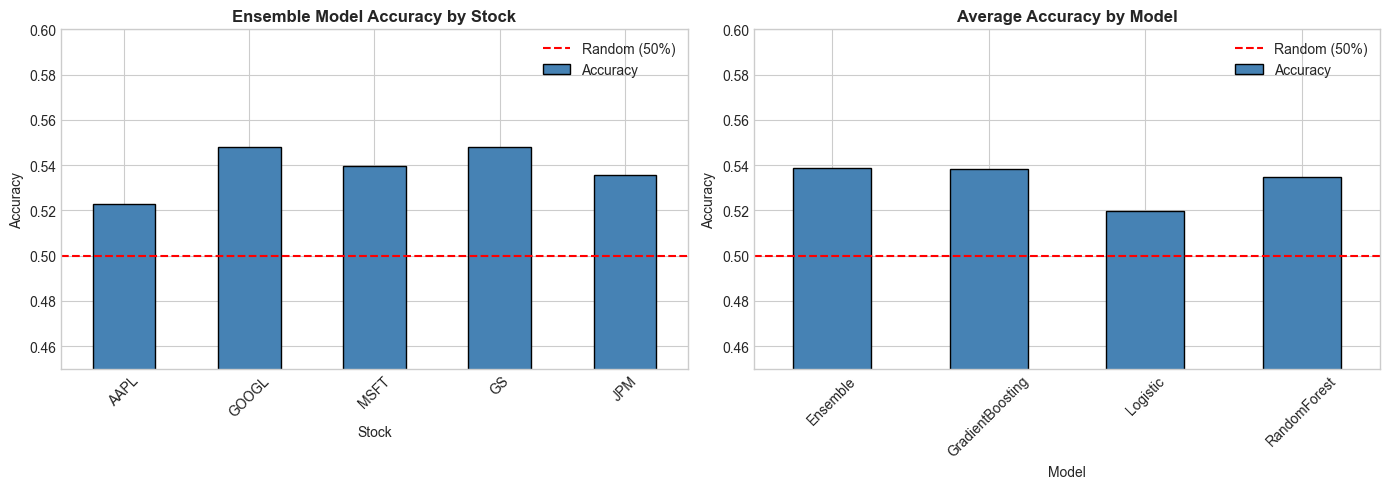


✅ CAPSTONE PROJECT COMPLETE


In [7]:
# Phase 6: Performance Summary
print("\n" + "="*60)
print("PHASE 6: MODEL PERFORMANCE SUMMARY")
print("="*60)

# Compile results
performance_data = []
for stock in STOCKS:
    for model_name, metrics in all_results[stock].items():
        performance_data.append({
            'Stock': stock,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'F1': metrics['f1']
        })

perf_df = pd.DataFrame(performance_data)

# Summary by model
model_summary = perf_df.groupby('Model').agg({
    'Accuracy': 'mean',
    'Precision': 'mean',
    'F1': 'mean'
}).round(4)

print("\nAverage Performance by Model:")
print(model_summary.to_string())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy by stock
ensemble_acc = perf_df[perf_df['Model'] == 'Ensemble'].set_index('Stock')['Accuracy']
ax1 = axes[0]
ensemble_acc.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
ax1.axhline(0.5, color='red', linestyle='--', label='Random (50%)')
ax1.set_title('Ensemble Model Accuracy by Stock', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.45, 0.60)
ax1.legend()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Model comparison
ax2 = axes[1]
model_summary['Accuracy'].plot(kind='bar', ax=ax2, color='steelblue', edgecolor='black')
ax2.axhline(0.5, color='red', linestyle='--', label='Random (50%)')
ax2.set_title('Average Accuracy by Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0.45, 0.60)
ax2.legend()
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("✅ CAPSTONE PROJECT COMPLETE")
print(f"{'='*70}")

## 🎯 Key Takeaways

1. **Data Pipeline**: Always validate and clean data before modeling
2. **Feature Engineering**: Use domain knowledge (technical indicators, cross-asset)
3. **Model Training**: Use time series CV, avoid look-ahead bias
4. **Ensemble Methods**: Combine multiple models for robustness
5. **Risk Management**: Cap position sizes, monitor exposure

## 📚 Skills Demonstrated

- End-to-end ML pipeline development
- Financial feature engineering
- Ensemble model training
- Portfolio optimization
- Risk management
- Production-ready code structure